In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns



def get_windows(job,n_neighbors):
    '''
    For each region and each individual cell in dataset, return the indices of the nearest neighbors.
    
    'job:  meta data containing the start time,index of region, region name, indices of region in original dataframe
    n_neighbors:  the number of neighbors to find for each cell
    '''
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

#     fit = NearestNeighbors(n_neighbors=n_neighbors+1).fit(tissue[[X,Y]].values)
    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)
#     m = m[0][:,1:], m[1][:,1:]
    m = m[0], m[1]
    

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)


### ------------------------

### Fill In:
    -ks = individual window sizes to collect.  
        -This accelerates the process of trying different window sizes by collecting them all in one step.
    -path_to_data:  file path for csv file with x,y cluster information
    -X:  column to use for X location
    -Y:  column to use for Y location
    -reg:  column to use for region (should be different for every tissue)
    -file_type('csv','pickle'):  file type
    -cluster_col : column name of cell type cluster to be used for neighborhoods
    -cellhierpath:  path to cellhier libary (should only have to set once per computer
    -keep_cols:  columns to transfer from original dataframe to dataframe with windows and neighborhoods

In [2]:
ks = [5,10,50,100] # k=5 means it collects 5 nearest neighbors for each center cell
path_to_data = '/mnt/isilon/tan_lab_imaging/Analysis/bandyopads/NBM_CODEX_Atlas/Combined_Analysis/Seurat/ReferenceMap_AML_Step6/For_Neighborhoods/NSM_AML_combined_annotated_ForNeighborhoods.csv'
X = 'x.coord'
Y = 'y.coord_rev'
reg = 'orig.ident'
file_type = 'csv'

cluster_col = 'classified_cluster_anno_l2'
keep_cols = [X,Y,reg,cluster_col]
save_path = '/mnt/isilon/tan_lab_imaging/Analysis/bandyopads/NBM_CODEX_Atlas/Combined_Analysis/Seurat/ReferenceMap_AML_Step6/NeighborhoodsOutput/'


### ------------------------

In [3]:
#read in data and do some quick data rearrangement
n_neighbors = max(ks)
assert (file_type=='csv' or file_type =='pickle') #


if file_type == 'pickle':
    cells = pd.read_pickle(path_to_data)
if file_type == 'csv':
    cells = pd.read_csv(path_to_data)

cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],1)


#cells = cells.reset_index() #Uncomment this line if you do any subsetting of dataframe such as removing dirt etc or will throw error at end of next next code block (cell 6)

sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values

/tmp/ipykernel_529654/1593009386.py:9: DtypeWarning: Columns (73,75) have mixed types. Specify dtype option on import or set low_memory=False.
  cells = pd.read_csv(path_to_data)
/tmp/ipykernel_529654/1593009386.py:11: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],1)


In [4]:
#find windows for each cell in each tissue region
tissue_group = cells[[X,Y,reg]].groupby(reg)
exps = list(cells[reg].unique())
tissue_chunks = [(time.time(),exps.index(t),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]


Starting: 6/8 : SB67_NBM44_AML2_191_CODEX_Mesmer
Finishing: 6/8 : SB67_NBM44_AML2_191_CODEX_Mesmer 1.168015718460083 1.1688759326934814
Starting: 5/8 : SB67_NBM46_AML1_382_CODEX_Mesmer
Finishing: 5/8 : SB67_NBM46_AML1_382_CODEX_Mesmer 1.2169098854064941 2.396263837814331
Starting: 3/8 : SB67_NBM47_NSM3_1996_CODEX_Mesmer
Finishing: 3/8 : SB67_NBM47_NSM3_1996_CODEX_Mesmer 0.5687041282653809 2.9792497158050537
Starting: 1/8 : SB67_NBM48_NSM1_1720_CODEX_Mesmer
Finishing: 1/8 : SB67_NBM48_NSM1_1720_CODEX_Mesmer 2.923022508621216 5.907251596450806
Starting: 2/8 : SB67_NBM49_NSM2_1086_CODEX_Mesmer
Finishing: 2/8 : SB67_NBM49_NSM2_1086_CODEX_Mesmer 0.23000049591064453 6.1633172035217285
Starting: 4/8 : SB67_NBM51_AML1_183_CODEX_Mesmer
Finishing: 4/8 : SB67_NBM51_AML1_183_CODEX_Mesmer 0.15366077423095703 6.319263219833374
Starting: 7/8 : SB67_NBM52_AML3_1329_CODEX_Mesmer
Finishing: 7/8 : SB67_NBM52_AML3_1329_CODEX_Mesmer 0.6258556842803955 6.945823431015015
Starting: 8/8 : SB67_NBM54_AML3_1443_

In [5]:
#for each cell and its nearest neighbors, reshape and count the number of each cell type in those neighbors.
out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):

        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(tissue_name,k)] = (window.astype(np.float16),indices)

#concatenate the summed windows and combine into one dataframe for each window size tested.
windows = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window],1)
    windows[k] = window


/tmp/ipykernel_529654/2968920925.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
/tmp/ipykernel_529654/2968920925.py:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([cells[keep_cols],window],1)
/tmp/ipykernel_529654/2968920925.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
/tmp/ipykernel_529654/2968920925.py:18: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([cells[

### ------------------------

### Fill In:
    -k:  window_size (needs to be in ks (saved above))
    -n_neighborhoods:  number of neighborhoods to find

In [6]:
# 1 Follicular (Crohn's Like)
# 2 Diffuse

In [7]:
k = 10
n_neighborhoods = 15
neighborhood_name = "neighborhood"+str(k)
k_centroids = {}

In [8]:
windows2 = windows[10]
# windows2[cluster_col] = cells[cluster_col]

km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

labelskm = km.fit_predict(windows2[sum_cols].values)
k_centroids[k] = km.cluster_centers_
cells['neighborhood10'] = labelskm
cells[neighborhood_name] = cells[neighborhood_name].astype('category')
#['reg064_A','reg066_A','reg018_B','reg023_A']


In [9]:
cell_order = ["AEC","B-Cell", "CD10+ HSPC", "CD4+ T-Cell", 
             "CD8+ T-Cell", "Dendritic Cells", "Early Myeloid Progenitor", "Endothelial","Erythroblast",
             "Erythroid", "GMP", "HSPC", "Immature_B_Cell", "Macrophage",
             "MastCells", "Mature Myeloid", "Megakaryocyte", "Monocyte","MSC",
             "Myeloid Progenitor", "Plasma Cell", "Schwann Cells", "SEC", "SPINK2+ HSPC", "Stromal",
             "VSMC"]    

cell_order = ["NPM1 Mutant Blast","HSC", "SPINK2+ HSPC", "HSPC", "GMP","GMP/Myeloblast","Early Myeloid Progenitor", "Intermediate Myeloid", "Mature Myeloid",
             "pDC", "Monocytes","Non-Classical Monocyte","Macrophages", "MEP/Early Erythroblast", "Erythroblast", "Erythroid", "CD34+ CD61+", "GATA1neg_Mks", "GATA1pos_Mks",
             "CLP","Immature_B_Cell", "B-Cells","Plasma Cells", "CD4+ T-Cell", "CD8+ T-Cell", "SEC", "AEC","VSMC", "Schwann Cells", "MSC", "THY1+ MSC", "Endosteal", "Adipocyte"]




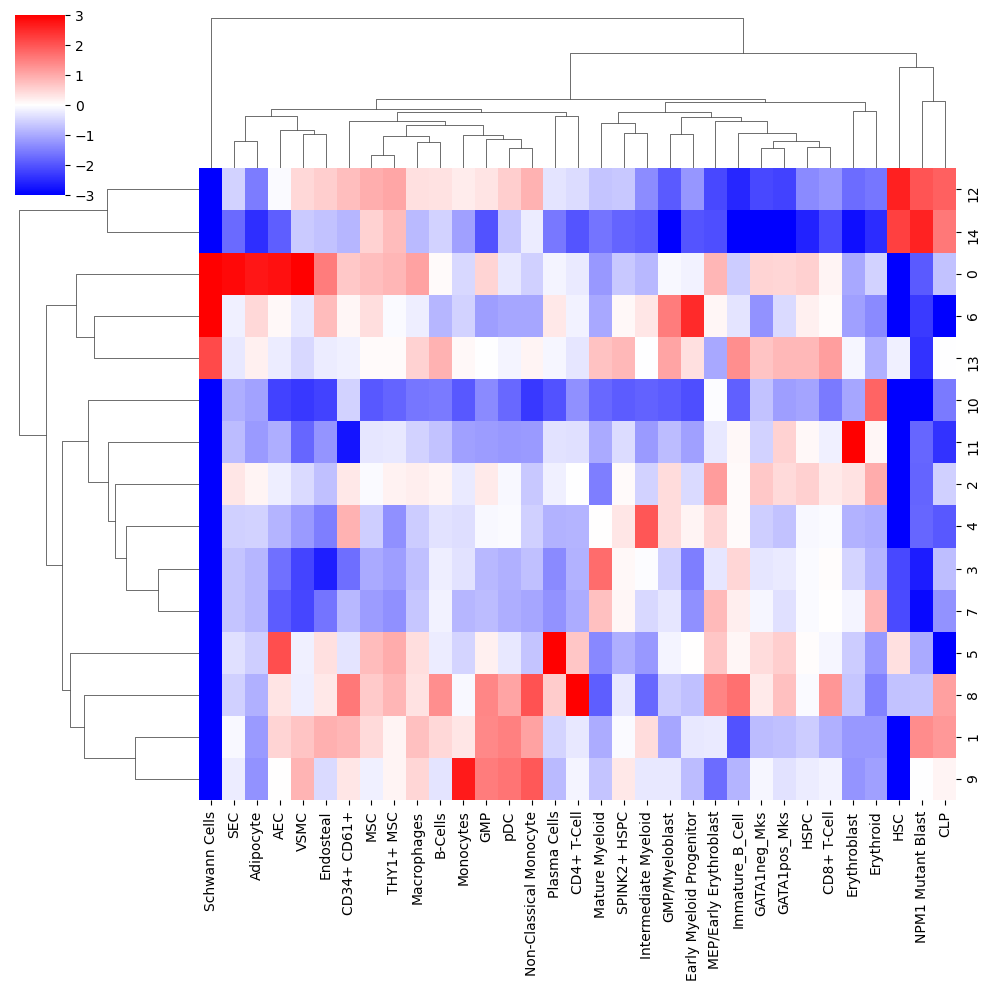

In [11]:
# this plot shows the types of cells (ClusterIDs) in the different niches (0-7)
k_to_plot = 10
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14],cell_order], vmin =-3,vmax = 3,cmap = 'bwr',row_cluster = True)
# s=sns.clustermap(fc.loc[[0,1,2,3,4],cell_order], vmin =-3,vmax = 3,cmap = 'bwr',row_cluster = False)
# s.savefig("raw_figs/celltypes_perniche_10.pdf")


In [ ]:
# save files for downstream analysis
cells.to_csv("/mnt/isilon/tan_lab_imaging/Analysis/bandyopads/NBM_CODEX_Atlas/Combined_Analysis/Seurat/ReferenceMap_AML_Step6/NeighborhoodsOutput/AML_NSM_combined.neighborhood.csv")
fc.to_csv("/mnt/isilon/tan_lab_imaging/Analysis/bandyopads/NBM_CODEX_Atlas/Combined_Analysis/Seurat/ReferenceMap_AML_Step6/NeighborhoodsOutput/AML_NSM.combined_neighborhood_fc.csv")